<a href="https://colab.research.google.com/github/r-rahul1/Tweet_Emotion_Recognition/blob/main/Tweet_Emotion_Recognition_Learner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Tweet Emotion Recognition: Natural Language Processing with TensorFlow

---

Dataset: [Tweet Emotion Dataset](https://github.com/dair-ai/emotion_dataset)

Coursera guided project: [Tweet Emotion Recognition with TensorFlow](https://www.coursera.org/projects/tweet-emotion-tensorflow)
---

1. Installing Hugging Face's nlp package
2. Importing libraries

In [1]:
!pip install nlp

     |████████████████████████████████| 1.7 MB 5.4 MB/s 
     |████████████████████████████████| 243 kB 49.6 MB/s 


In [2]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random


def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    
def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()


Using TensorFlow version 2.7.0



1. Importing the Tweet Emotion dataset
2. Creating train, validation and test sets
3. Extracting tweets and labels from the examples

In [3]:
dataset=nlp.load_dataset('emotion')

Downloading:   0%|          | 0.00/3.41k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/6.01k [00:00<?, ?B/s]

Using custom data configuration default


Downloading: 0.00B [00:00, ?B/s]

Downloading: 0.00B [00:00, ?B/s]

Downloading: 0.00B [00:00, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/84e07cd366f4451464584cdbd4958f512bcaddb1e921341e07298ce8a9ce42f4. Subsequent calls will reuse this data.


In [4]:
dataset

{'test': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000),
 'train': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 16000),
 'validation': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000)}

In [5]:
train=dataset['train']
val=dataset['validation']
test=dataset['test']

In [6]:
def get_tweet(data):
  tweets=[x['text'] for x in data]
  labels=[x['label'] for x in data]
  return tweets,labels

In [7]:
tweets,labels=get_tweet(train)

In [8]:
tweets[0],labels[0]

('i didnt feel humiliated', 'sadness')


1. Tokenizing the tweets

In [9]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [10]:
tokenizer = Tokenizer(num_words=10000,oov_token='<unk>')
tokenizer.fit_on_texts(tweets)

In [11]:
tokenizer.texts_to_sequences([tweets[0]])

[[2, 139, 3, 679]]


1. Checking length of the tweets
2. Creating padded sequences

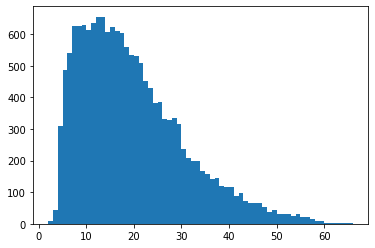

In [12]:
lengths = [len(i.split(' '))for i in tweets]
plt.hist(lengths,bins=len(set(lengths)))
plt.show()

In [13]:
max_len=50

from tensorflow.keras.preprocessing.sequence import pad_sequences

In [14]:
def get_sequences(tokenizer,tweets):
  sequences=tokenizer.texts_to_sequences(tweets)
  padded=pad_sequences(sequences,truncating='post',padding='post',maxlen=max_len)
  return padded

In [15]:
padded_train=get_sequences(tokenizer,tweets)

In [16]:
padded_train[0]

array([  2, 139,   3, 679,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)


1. Creating classes to index and index to classes dictionaries
2. Converting text labels to numeric labels

In [17]:
classes = set(labels)
print(classes)

{'anger', 'surprise', 'love', 'fear', 'sadness', 'joy'}


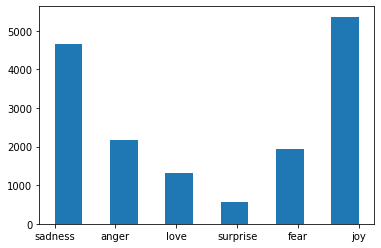

In [18]:
plt.hist(labels,bins=11)
plt.show()

In [19]:
classes_to_index=dict((c,i) for i,c in enumerate(classes))
index_to_class=dict((v,k) for k,v in classes_to_index.items())

In [20]:
classes_to_index

{'anger': 0, 'fear': 3, 'joy': 5, 'love': 2, 'sadness': 4, 'surprise': 1}

In [21]:
name_to_ids=lambda labels:np.array([classes_to_index.get(x) for x in labels])

In [22]:
train_labels= name_to_ids(labels)
print(train_labels[0])

4


In [23]:
index_to_class

{0: 'anger', 1: 'surprise', 2: 'love', 3: 'fear', 4: 'sadness', 5: 'joy'}


1. Creating the model
2. Compiling the model

In [24]:
model = tf.keras.models.Sequential([
                                    tf.keras.layers.Embedding(10000,16,input_length=max_len),
                                    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20,return_sequences=True)),
                                    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
                                    tf.keras.layers.Dense(6,activation='softmax')
])
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 16)            160000    
                                                                 
 bidirectional (Bidirectiona  (None, 50, 40)           5920      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 40)               9760      
 nal)                                                            
                                                                 
 dense (Dense)               (None, 6)                 246       
                                                                 
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________


## Training the Model

1. Preparing a validation set
2. Training the model

In [26]:
val_tweets, val_labels = get_tweet(val)
val_seq = get_sequences(tokenizer, val_tweets)
val_labels= name_to_ids(val_labels)

In [27]:
val_tweets[0],val_labels[0]

('im feeling quite sad and sorry for myself but ill snap out of it soon', 4)

In [28]:
h= model.fit(
    padded_train, train_labels,
    validation_data=(val_seq,val_labels),
    epochs=20,
    callbacks=[
               tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=2)
    ]
)

Epoch 1/20
500/500 [==============================] - 39s 60ms/step - loss: 1.2353 - accuracy: 0.5084 - val_loss: 0.6749 - val_accuracy: 0.7560
Epoch 2/20
500/500 [==============================] - 28s 57ms/step - loss: 0.4876 - accuracy: 0.8236 - val_loss: 0.4903 - val_accuracy: 0.8365
Epoch 3/20
500/500 [==============================] - 28s 56ms/step - loss: 0.2760 - accuracy: 0.9080 - val_loss: 0.4284 - val_accuracy: 0.8540
Epoch 4/20
500/500 [==============================] - 28s 56ms/step - loss: 0.1781 - accuracy: 0.9413 - val_loss: 0.4121 - val_accuracy: 0.8745
Epoch 5/20
500/500 [==============================] - 28s 56ms/step - loss: 0.1343 - accuracy: 0.9543 - val_loss: 0.3868 - val_accuracy: 0.8870
Epoch 6/20
500/500 [==============================] - 28s 56ms/step - loss: 0.1089 - accuracy: 0.9649 - val_loss: 0.3938 - val_accuracy: 0.8900
Epoch 7/20
500/500 [==============================] - 28s 56ms/step - loss: 0.0887 - accuracy: 0.9703 - val_loss: 0.4009 - val_accuracy:

## Evaluating the Model

1. Visualizing training history
2. Prepraring a test set
3. A look at individual predictions on the test set
4. A look at all predictions on the test set

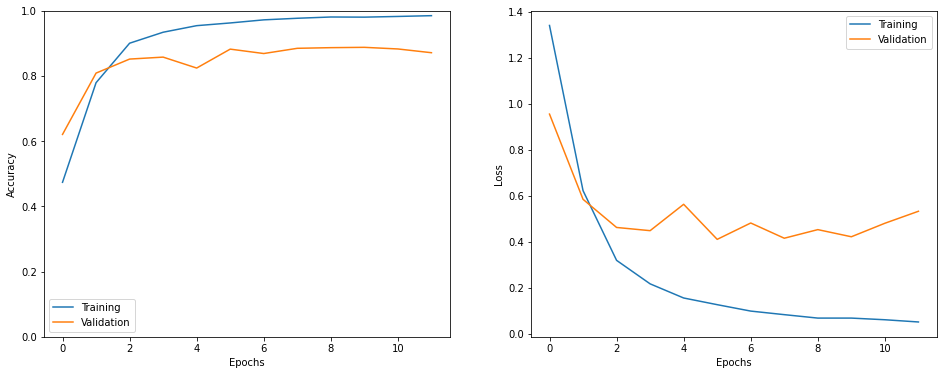

In [ ]:
show_history(h)

In [ ]:
test_tweets, test_labels= get_tweet(test)
test_seq=get_sequences(tokenizer,test_tweets)
test_labels= name_to_ids(test_labels)

In [ ]:
_ = model.evaluate(test_seq,test_labels)

63/63 [==============================] - 0s 7ms/step - loss: 0.5346 - accuracy: 0.8635


In [ ]:
i= random.randint(0,len(test_labels)-1)

print('Sentence:',test_tweets[i])
print('Emotion:',index_to_class[test_labels[i]])

p=model.predict(np.expand_dims(test_seq[i],axis=0))[0]
pred_class=index_to_class[np.argmax(p).astype('uint8')]

print('predicted Emotion:', pred_class)

Sentence: i hope it is because he understands the way i feel i hope he sees what he could miss and is putting the petty negative thoughts aside
Emotion: anger
predicted Emotion: anger


In [ ]:
preds=model.predict_classes(test_seq)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


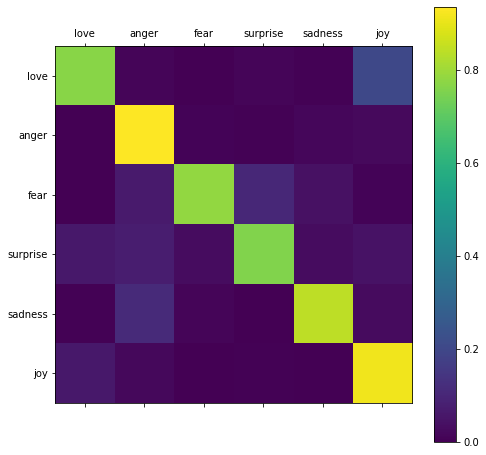

In [ ]:
show_confusion_matrix(test_labels,preds,list(classes))

In [29]:
tf.keras.layers.Embedding(10000, 32, input_length=50)